In [1]:
import tensorflow as tf
import numpy as np
import gpflow
from gpflow.inducing_variables import InducingVariables
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from tensorflow.linalg import LinearOperatorBlockDiag as BlockDiag, \
    LinearOperatorDiag as Diag, \
    LinearOperatorLowRankUpdate as LowRank, \
    LinearOperatorFullMatrix as FullMatrix

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
TensorLike = object  # Union of np.ndarray, tf.Tensor, tf.Variable, gpflow.Parameter...

In [4]:
@cov.Kuu.register(InducingVariables, gpflow.kernels.Kernel)
def Kuu_fallback(inducing_variable, kernel, **kw):
    from warnings import warn
    warn('Kuu(inducing_variable, kernel) is deprecated, please use '
         'Kuu(kernel, inducing_variable) instead.',
         DeprecationWarning)
    return cov.Kuu(kernel, inducing_variable, **kw)

@cov.Kuf.register(InducingVariables, gpflow.kernels.Kernel, TensorLike)
def Kuf_fallback(inducing_variable, kernel, X):
    from warnings import warn
    warn('Kuf(inducing_variable, kernel, X) is deprecated, please use '
         'Kuf(kernel, inducing_variable, X) instead.',
         DeprecationWarning)
    return cov.Kuf(kernel, inducing_variable, X)

In [5]:
class FourierFeatures1D(InducingVariables):
    def __init__(self, a, b, M):
        self.a, self.b = a, b
        self.ms = np.arange(M)
    
    def __len__(self):
        return 2 * len(self.ms) - 1

@cov.Kuu.register(gpflow.kernels.Matern12, FourierFeatures1D)
def Kuu_matern12_fourierfeatures1d(kernel, inducing_variable, jitter=None):
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2. * np.pi * ms / (b - a)
    
    # cos part first
    lamb = 1./ kernel.lengthscale
    two_or_four = np.where(omegas == 0, 2., 4.)
    d_cos = (b - a) * (tf.square(lamb) + tf.square(omegas)) \
        / lamb / kernel.variance / two_or_four
    v_cos = tf.ones_like(d_cos) / tf.sqrt(kernel.variance)

    # now the sin part
    omegas = omegas[omegas != 0]  # don't compute omega=0
    d_sin = (b - a) * (tf.square(lamb) + tf.square(omegas)) \
        / lamb / kernel.variance / 4.
    return BlockDiag([LowRank(Diag(d_cos), v_cos[:, None]), Diag(d_sin)])

@cov.Kuf.register(gpflow.kernels.Matern12, FourierFeatures1D, TensorLike)
def Kuf_matern12_fourierfeatures1d(kernel, inducing_variable, X):
    a, b, ms = (lambda u: (u.a, u.b, u.ms))(inducing_variable)
    omegas = 2. * np.pi * ms / (b-a)
    Kuf_cos = tf.transpose(tf.cos(omegas * (X - a)))
    omegas_sin = omegas[omegas != 0]  # don't compute zeros freq.
    Kuf_sin = tf.transpose(tf.sin(omegas_sin * (X - a)))

    # correct Kfu outside [a, b]
    lt_a_sin = tf.tile(tf.transpose(X) < a, [len(ms)-1, 1])
    gt_b_sin = tf.tile(tf.transpose(X) > b, [len(ms)-1, 1])
    lt_a_cos = tf.tile(tf.transpose(X) < a, [len(ms), 1])
    gt_b_cos = tf.tile(tf.transpose(X) > b, [len(ms), 1])
    
    # Kuf_sin[:, np.logical_or(X.flatten() < a, X.flatten() > b)] = 0
    Kuf_sin = tf.where(tf.logical_or(lt_a_sin, gt_b_sin), tf.zeros_like(Kuf_sin), Kuf_sin)
    Kuf_cos = tf.where(lt_a_cos, tf.tile(tf.exp(-tf.abs(tf.transpose(X-a))/kernel.lengthscale), [len(ms), 1]), Kuf_cos)
    Kuf_cos = tf.where(gt_b_cos, tf.tile(tf.exp(-tf.abs(tf.transpose(X-b))/kernel.lengthscale), [len(ms), 1]), Kuf_cos)

    return tf.concat([Kuf_cos, Kuf_sin], axis=0)

In [6]:
@kl.prior_kl.register(FourierFeatures1D, gpflow.kernels.Kernel, TensorLike, TensorLike)
def prior_kl_vff(inducing_variable, kernel, q_mu, q_sqrt, whiten=False):
    if whiten:
        raise NotImplementedError
    K = cov.Kuu(kernel, inducing_variable)
    return gauss_kl_vff(q_mu, q_sqrt, K)

def gauss_kl_vff(q_mu, q_sqrt, K):
    """
    Compute the KL divergence from

          q(x) = N(q_mu, q_sqrt^2)
    to
          p(x) = N(0, K)

    q_mu is a vector [N, 1] that contains the mean.
    q_sqrt is a matrix that is the lower triangular square-root matrix of the covariance of q.

    K is a positive definite matrix: the covariance of p.
    NOTE: K is a LinearOperator that provides efficient methjods
        for solve(), log_abs_determinant(), and trace()
    """
    # KL(N₀ || N₁) = ½ [tr(Σ₁⁻¹ Σ₀) + (μ₁ - μ₀)ᵀ Σ₁⁻¹ (μ₁ - μ₀) - k + ln(det(Σ₁)/det(Σ₀))]
    # N₀ = q; μ₀ = q_mu, Σ₀ = q_sqrt q_sqrtᵀ
    # N₁ = p; μ₁ = 0, Σ₁ = K
    # KL(q || p) =
    #     ½ [tr(K⁻¹ q_sqrt q_sqrtᵀA + q_muᵀ K⁻¹ q_mu - k + logdet(K) - logdet(q_sqrt q_sqrtᵀ)]
    # k = number of dimensions, if q_sqrt is m x m this is m²
    Kinv_q_mu = K.solve(q_mu)
    
    mahalanobis_term = tf.matmul(q_mu, Kinv_q_mu, transpose_a=True)

    # GPflow: q_sqrt is num_latent x N x N
    num_latent = tf.cast(tf.shape(q_mu)[1], gpflow.default_float())
    logdet_prior = num_latent * K.log_abs_determinant()

    product_of_dimensions__int = tf.reduce_prod(tf.shape(q_sqrt)[:-1])  # dimensions are integers
    constant_term = tf.cast(product_of_dimensions__int, gpflow.default_float())

    Lq = tf.linalg.band_part(q_sqrt, -1, 0)  # force lower triangle
    logdet_q = tf.reduce_sum(tf.math.log(tf.square(tf.linalg.diag_part(Lq))))

    # S = tf.matmul(q_sqrt, q_sqrt, transpose_b=True)
    # trace_term = tf.trace(K.solve(S))
    trace_term = tf.reduce_sum(Lq * K.solve(Lq), axis=[-1, -2])  # [O(N²) instead of O(N³)

    twoKL = trace_term + mahalanobis_term - constant_term + logdet_prior - logdet_q
    return 0.5 * twoKL

In [7]:
@gpflow.conditionals.conditional.register(TensorLike, FourierFeatures1D, gpflow.kernels.Kernel, TensorLike)
def conditional_vff(Xnew, inducing_variable, kernel, f, *, full_cov=False, full_output_cov=False, q_sqrt=None, white=False):
    """
     - Xnew are the points of the data or minibatch, size N x D (tf.array, 2d)
     - feat is an instance of features.InducingFeature that provides `Kuu` and `Kuf` methods
       for Fourier features, this contains the limits of the bounding box and the frequencies
     - f is the value (or mean value) of the features (i.e. the weights)
     - q_sqrt (default None) is the Cholesky factor of the uncertainty about f
       (to be propagated through the conditional as per the GPflow inducing-point implementation)
     - white (defaults False) specifies whether the whitening has been applied

    Given the GP represented by the inducing points specified in `feat`, produce the mean and
    (co-)variance of the GP at the points Xnew.

       Xnew :: N x D
       Kuu :: M x M
       Kuf :: M x N
       f :: M x K, K = 1
       q_sqrt :: K x M x M, with K = 1
    """
    if full_output_cov:
        raise NotImplementedError

    # num_data = tf.shape(Xnew)[0]  # M
    num_func = tf.shape(f)[1]  # K
    # compute kernel stuff
    Kuu = cov.Kuu(kernel, inducing_variable)  # LinearOperator
    Kuf = cov.Kuf(kernel, inducing_variable, Xnew)

    KuuInv_Kuf = Kuu.solve(Kuf)

    # compute the covariance due to the conditioning
    if full_cov:
        fvar = kernel(Xnew) - tf.matmul(Kuf, KuuInv_Kuf, transpose_a=True)
        shape = (num_func, 1, 1)
    else:
        KufT_KuuInv_Kuf_diag = tf.reduce_sum(Kuf * KuuInv_Kuf, axis=-2)
        fvar = kernel(Xnew, full=False) - KufT_KuuInv_Kuf_diag
        shape = (num_func, 1)
    fvar = tf.expand_dims(fvar, 0) * tf.ones(shape, dtype=gpflow.default_float())  # K x N x N or K x N

    # another backsubstitution in the unwhitened case
    if white:
        raise NotImplementedError

    A = KuuInv_Kuf

    # construct the conditional mean
    fmean = tf.matmul(A, f, transpose_a=True)

    if q_sqrt is not None:
        if q_sqrt.get_shape().ndims == 2:
            # LTA = A * tf.expand_dims(q_sqrt, 2)  # K x M x N
            # won't work  # make ticket for this?
            raise NotImplementedError
        elif q_sqrt.get_shape().ndims == 3:
            # L = tf.matrix_band_part(tf.transpose(q_sqrt, (2, 0, 1)), -1, 0)  # K x M x M

            # K x M x N
            # A_tiled = tf.expand_dims(A.get(), 0) * tf.ones((num_func, 1, 1), dtype=float_type)

            # LTA = tf.matmul(L, A_tiled, transpose_a=True)  # K x M x N
            # TODO the following won't work for K > 1
            assert q_sqrt.shape[0] == 1
            # LTA = (A.T @ DenseMatrix(q_sqrt[:,:,0])).T.get()[None, :, :]
            ATL = tf.matmul(A, q_sqrt, transpose_a=True)
        else:
            raise ValueError("Bad dimension for q_sqrt: %s" %
                             str(q_sqrt.get_shape().ndims))
        if full_cov:
            # fvar = fvar + tf.matmul(LTA, LTA, transpose_a=True)  # K x N x N
            fvar = fvar + tf.matmul(ATL, ATL, transpose_b=True)  # K x N x N
        else:
            # fvar = fvar + tf.reduce_sum(tf.square(LTA), 1)  # K x N
            fvar = fvar + tf.reduce_sum(tf.square(ATL), 2)  # K x N
    fvar = tf.transpose(fvar)  # N x K or N x N x K

    return fmean, fvar

In [8]:
X = np.linspace(-2, 2, 51)
Xnew = np.linspace(-4, 4, 501)
def f(x):
    return np.sin(2*np.pi * x / 4 * 2)
F = f(X)
Fnew = f(Xnew)
Y = F + np.random.randn(*F.shape) * 0.1

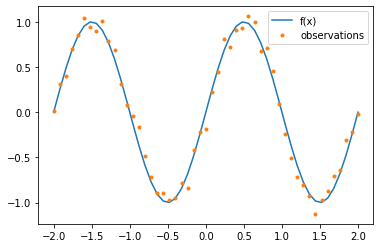

In [9]:
plt.figure()
plt.plot(X, F, label='f(x)')
plt.plot(X, Y, '.', label='observations')
plt.legend()
plt.show()

In [10]:
m = gpflow.models.SVGP(kernel=gpflow.kernels.Matern12(),
                       likelihood=gpflow.likelihoods.Gaussian(variance=0.1**2),
                       inducing_variables=FourierFeatures1D(-2, 2, 9),
                       num_data=len(X), whiten=False)

@tf.function(autograph=False)
def objective():
    return m.neg_log_marginal_likelihood(X.reshape(-1,1), Y.reshape(-1,1))

In [11]:
opt = gpflow.optimizers.Scipy()
opt.minimize(objective,
             variables=m.trainable_variables,
             options=dict(maxiter=2500), method='L-BFGS-B')  # TODO: make work with BFGS

gpflow.utilities.print_summary(m, fmt='notebook')

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


name,class,transform,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,True,(),float64,0.1483062702104303
SVGP.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.4685556100911875
SVGP.likelihood.variance,Parameter,Softplus,True,(),float64,0.046532003756647684
SVGP.q_mu,Parameter,,True,"(17, 1)",float64,[[3.53612628e-01...
SVGP.q_sqrt,Parameter,FillTriangular,True,"(1, 17, 17)",float64,"[[[1.18661853e+00, 0.00000000e+00, 0.00000000e+00..."


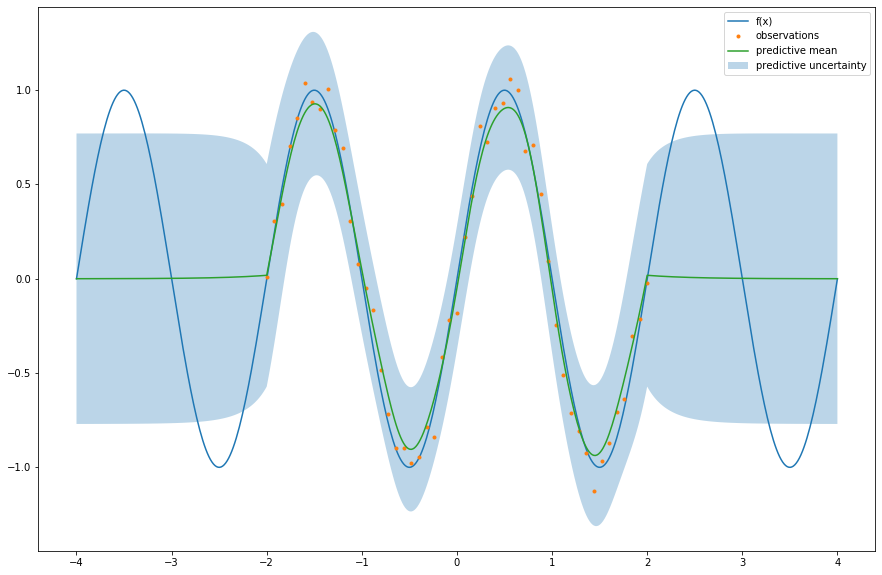

In [12]:
plt.figure(figsize=(15,10))
plt.plot(Xnew, Fnew, label='f(x)')
plt.plot(X, Y, '.', label='observations')
Fmean, Fvar = m.predict_f(Xnew[:, None])
Fmean = Fmean.numpy().squeeze()
Fvar = Fvar.numpy().squeeze()
plt.plot(Xnew, Fmean, label='predictive mean')
plt.fill_between(Xnew, Fmean - 2 * np.sqrt(Fvar), Fmean + 2 * np.sqrt(Fvar), alpha=0.3,
                 label='predictive uncertainty')
plt.legend(loc='best')
plt.show()